In [10]:
!pip -q install facenet-pytorch
import sys, subprocess
!pip -q install timm facenet-pytorch

In [ ]:
import os
import torch
import torch.nn.functional as F
import timm
from PIL import Image
from facenet_pytorch import MTCNN
import glob
!pip -q install tqdm
from tqdm.auto import tqdm
import random
from collections import defaultdict

import numpy as np


import matplotlib.pyplot as plt
import cv2
np.bool = np.bool_ 

import mxnet as mx 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import io
import copy
import pandas as pd
import seaborn as sns

In [12]:



os.environ["HF_HOME"] = "/kaggle/working/hf"

device = "cuda" if torch.cuda.is_available() else "cpu"

mtcnn = MTCNN(image_size=112, margin=0, post_process=True, device=device)

vit = timm.create_model(
    "hf_hub:gaunernst/vit_tiny_patch8_112.cosface_ms1mv3",
    pretrained=True
).to(device).eval()

In [13]:

print("Datasets under /kaggle/input:")
print(os.listdir("/kaggle/input")[:50])

imgs = glob.glob("/kaggle/input/**/*.*", recursive=True)
imgs = [p for p in imgs if p.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp"))]
print("num images found:", len(imgs))
print("first 20 images:")
print("\n".join(imgs[:20]))


Datasets under /kaggle/input:
['ms1mv3', 'lfw-dataset']
num images found: 13233
first 20 images:
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Tyler_Hamilton/Tyler_Hamilton_0002.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Tyler_Hamilton/Tyler_Hamilton_0001.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Bernard_Siegel/Bernard_Siegel_0001.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Blythe_Danner/Blythe_Danner_0002.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Blythe_Danner/Blythe_Danner_0001.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Gene_Robinson/Gene_Robinson_0003.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Gene_Robinson/Gene_Robinson_0004.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Gene_Robinson/Gene_Robinson_0001.jpg
/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Gene_Robinson/Gene_Robinson_0005.jpg
/kaggle/input/lfw-datase

Using DATA_ROOT: /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled
Identities with >=2 images: 1680
Gallery: 1680 Probes: 3191


align gallery:   0%|          | 0/1680 [00:00<?, ?img/s]

align probe:   0%|          | 0/3191 [00:00<?, ?img/s]

Kept gallery: 1679 Kept probes: 3191


embed:   0%|          | 0/27 [00:00<?, ?batch/s]

embed:   0%|          | 0/50 [00:00<?, ?batch/s]

embed:   0%|          | 0/27 [00:00<?, ?batch/s]

embed:   0%|          | 0/50 [00:00<?, ?batch/s]

ViT  - Rank-1: 0.9279 | Rank-5: 0.9336
CNN  - Rank-1: 0.9289 | Rank-5: 0.9364


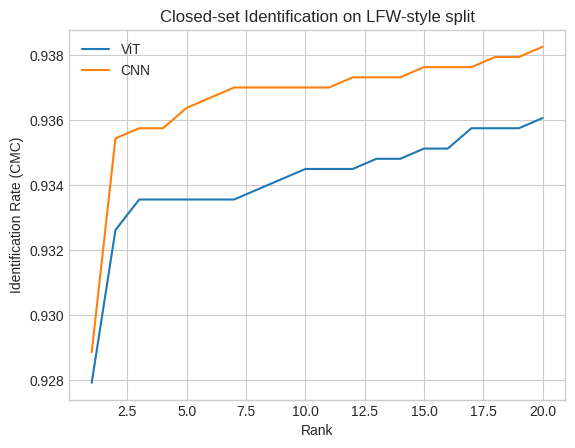

In [15]:





os.environ["HF_HOME"] = "/kaggle/working/hf"  
device = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

BATCH_SIZE = 64
MAX_IDENTITIES = 2000        
MAX_PROBES_PER_ID = 3        
GALLERY_PER_ID = 1           



def find_dataset_root():
    candidates = []
    for root in glob.glob("/kaggle/input/**", recursive=True):
        if not os.path.isdir(root): 
            continue
        subdirs = [d for d in glob.glob(os.path.join(root, "*")) if os.path.isdir(d)]
        if len(subdirs) == 0:
            continue
        img_count = 0
        for sd in subdirs[:10]:
            img_count += len(glob.glob(os.path.join(sd, "*.jpg")))
            img_count += len(glob.glob(os.path.join(sd, "*.png")))
            if img_count > 20:
                candidates.append(root)
                break
    if not candidates:
        raise RuntimeError("No dataset folders found under /kaggle/input. Did you add a dataset via 'Add data'?")
    candidates = sorted(set(candidates), key=lambda p: -p.count(os.sep))
    return candidates[0]

DATA_ROOT = find_dataset_root()
print("Using DATA_ROOT:", DATA_ROOT)



def build_id_map(root):
    id2paths = defaultdict(list)
    for person_dir in glob.glob(os.path.join(root, "*")):
        if not os.path.isdir(person_dir):
            continue
        person = os.path.basename(person_dir)
        imgs = []
        for ext in ("jpg", "jpeg", "png", "bmp", "webp"):
            imgs += glob.glob(os.path.join(person_dir, f"*.{ext}"))
        if len(imgs) >= 2: 
            id2paths[person].extend(sorted(imgs))
    return id2paths

id2paths = build_id_map(DATA_ROOT)
print("Identities with >=2 images:", len(id2paths))


ids = sorted(list(id2paths.keys()))
random.shuffle(ids)
ids = ids[:min(MAX_IDENTITIES, len(ids))]

gallery_paths = []
gallery_labels = []
probe_paths = []
probe_labels = []

label_map = {name: i for i, name in enumerate(ids)}

for name in ids:
    paths = id2paths[name]
    random.shuffle(paths)
    gallery_paths.append(paths[0])
    gallery_labels.append(label_map[name])

    probes = paths[1:1+MAX_PROBES_PER_ID]
    for p in probes:
        probe_paths.append(p)
        probe_labels.append(label_map[name])

print("Gallery:", len(gallery_paths), "Probes:", len(probe_paths))

mtcnn = MTCNN(image_size=112, margin=0, post_process=True, device=device)



REFERENCE_PTS = np.array([
    [38.2946, 51.6963],  # left eye
    [73.5318, 51.6963],  # right eye
    [56.0252, 71.7366],  # nose
    [41.5493, 92.3655],  # left mouth corner
    [70.7299, 92.3655]   # right mouth corner
], dtype=np.float32)

def align_face_warp(img, landmarks):
    """
    img: PIL Image or numpy array (H, W, 3)
    landmarks: list of 5 (x,y) points from MTCNN
    """
    if isinstance(img, Image.Image):
        img = np.array(img)
        
    src_pts = np.array(landmarks, dtype=np.float32)
    
    
    M, _ = cv2.estimateAffinePartial2D(src_pts, REFERENCE_PTS)
    
    warped = cv2.warpAffine(img, M, (112, 112))
    
    return Image.fromarray(warped)

def align_one(path):
    img = Image.open(path).convert("RGB")
    
   
    boxes, probs, points = mtcnn.detect(img, landmarks=True)
    
    if boxes is None:
        return None
        
    best_idx = np.argmax(probs)
    landmarks = points[best_idx]
    
    face_aligned = align_face_warp(img, landmarks)
    
    
    face_tensor = torch.tensor(np.array(face_aligned)).permute(2,0,1).float()
    face_tensor = (face_tensor - 127.5) / 128.0 
    return face_tensor


def align_paths(paths, desc="align"):
    faces = []
    kept_paths = []
    for p in tqdm(paths, desc=desc, unit="img"):
        face = align_one(p)
        if face is not None:
            faces.append(face)
            kept_paths.append(p)
    return faces, kept_paths


gallery_faces, gallery_paths_kept = align_paths(gallery_paths, "align gallery")
probe_faces, probe_paths_kept = align_paths(probe_paths, "align probe")

gallery_labels_kept = [gallery_labels[gallery_paths.index(p)] for p in gallery_paths_kept]
probe_labels_kept   = [probe_labels[probe_paths.index(p)] for p in probe_paths_kept]

print("Kept gallery:", len(gallery_faces), "Kept probes:", len(probe_faces))


vit = timm.create_model("hf_hub:gaunernst/vit_tiny_patch8_112.cosface_ms1mv3", pretrained=True).to(device).eval()

@torch.no_grad()
def embed(model, faces, batch_size=BATCH_SIZE, desc="embed"):
    embs = []
    for i in tqdm(range(0, len(faces), batch_size), desc=desc, unit="batch"):
        x = torch.stack(faces[i:i+batch_size]).to(device) 
        y = model(x)
        y = F.normalize(y, dim=1)
        embs.append(y.detach().cpu())
    return torch.cat(embs, dim=0)


g_vit = embed(vit, gallery_faces)
p_vit = embed(vit, probe_faces)

g_cnn = embed(cnn, gallery_faces)
p_cnn = embed(cnn, probe_faces)



def identification_metrics(g_emb, g_labels, p_emb, p_labels, max_rank=20):
    sim = p_emb @ g_emb.T  
    g_labels_t = torch.tensor(g_labels)
    p_labels_t = torch.tensor(p_labels)

    topk = torch.topk(sim, k=min(max_rank, sim.shape[1]), dim=1).indices 
    topk_labels = g_labels_t[topk]  

    correct = (topk_labels == p_labels_t.unsqueeze(1)) 
    rank1 = correct[:, 0].float().mean().item()
    rank5 = correct[:, :5].any(dim=1).float().mean().item() if sim.shape[1] >= 5 else float("nan")

    cmc = []
    for r in range(1, min(max_rank, sim.shape[1]) + 1):
        cmc.append(correct[:, :r].any(dim=1).float().mean().item())
    return rank1, rank5, cmc

rank1_vit, rank5_vit, cmc_vit = identification_metrics(g_vit, gallery_labels_kept, p_vit, probe_labels_kept)
rank1_cnn, rank5_cnn, cmc_cnn = identification_metrics(g_cnn, gallery_labels_kept, p_cnn, probe_labels_kept)

print(f"ViT  - Rank-1: {rank1_vit:.4f} | Rank-5: {rank5_vit:.4f}")
print(f"CNN  - Rank-1: {rank1_cnn:.4f} | Rank-5: {rank5_cnn:.4f}")


plt.figure()
plt.plot(range(1, len(cmc_vit)+1), cmc_vit, label="ViT")
plt.plot(range(1, len(cmc_cnn)+1), cmc_cnn, label="CNN")
plt.xlabel("Rank")
plt.ylabel("Identification Rate (CMC)")
plt.title("Closed-set Identification on LFW-style split")
plt.legend()
plt.show()


In [16]:

!pip uninstall -y mxnet-cu112 mxnet-cu110 mxnet
!pip install mxnet
!pip -q install torchattacks timm



CONFIG = {
    'batch_size': 64,
    'lr': 1e-4,                 
    'epochs': 10,              
    'max_epsilon': 0.1,         
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'rec_path': '/kaggle/input/ms1mv3/ms1m-retinaface-t1' 
}

class MXFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super(MXFaceDataset, self).__init__()
        self.transform = transform
        self.root_dir = root_dir
        path_imgrec = os.path.join(root_dir, 'train.rec')
        path_imgidx = os.path.join(root_dir, 'train.idx')
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)
        if header.flag > 0:
            self.imgidx = np.array(range(1, int(header.label[1])))
        else:
            self.imgidx = np.array(list(self.imgrec.keys))

    def __getitem__(self, index):
        while True:
            try:
                idx = self.imgidx[index]
                s = self.imgrec.read_idx(idx)
                header, img_bytes = mx.recordio.unpack(s)
                if len(img_bytes) == 0: raise ValueError
                img = Image.open(io.BytesIO(img_bytes))
                if img.mode != 'RGB': img = img.convert('RGB')
                if self.transform: img = self.transform(img)
                return img, 0 
            except:
                index = (index + 1) % len(self.imgidx)

    def __len__(self):
        return len(self.imgidx)

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print("Loading Dataset...")
train_dataset = MXFaceDataset(root_dir=CONFIG['rec_path'], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2, drop_last=True)

print("Initializing Teacher & Student...")
teacher_model = timm.create_model("hf_hub:gaunernst/vit_tiny_patch8_112.cosface_ms1mv3", pretrained=True).to(CONFIG['device'])
teacher_model.eval()
for param in teacher_model.parameters(): param.requires_grad = False

student_model = timm.create_model("hf_hub:gaunernst/vit_tiny_patch8_112.cosface_ms1mv3", pretrained=True).to(CONFIG['device'])
student_model.train()

optimizer = optim.Adam(student_model.parameters(), lr=CONFIG['lr'])

def train_pgd_attack(model, images, target_embs, eps, alpha=2/255, steps=5):
    adv_images = images.clone().detach()
    for _ in range(steps):
        adv_images.requires_grad = True
        curr_emb = torch.nn.functional.normalize(model(adv_images), dim=1)
        
       
        loss = (curr_emb * target_embs).sum()
        
        model.zero_grad()
        loss.backward()
        
        adv_images = adv_images - alpha * adv_images.grad.sign()
        eta = torch.clamp(adv_images - images, min=-eps, max=eps)
        adv_images = torch.clamp(images + eta, min=-1, max=1).detach()
    return adv_images

print("\n=== Starting Curriculum Training (FGSM -> PGD) ===")
MAX_BATCHES = 2000 

for epoch in range(CONFIG['epochs']):
    student_model.train()
    running_loss = 0.0
    
    current_eps = (epoch / CONFIG['epochs']) * CONFIG['max_epsilon']
    if epoch == 0: current_eps = 0.01 
    
    attack_type = 'FGSM'
    if epoch >= CONFIG['epochs'] // 2: 
        attack_type = 'PGD'
    
    print(f"Epoch {epoch+1}/{CONFIG['epochs']} | Eps: {current_eps:.4f} | Mode: {attack_type}")
    
    loop = tqdm(enumerate(train_loader), total=min(len(train_loader), MAX_BATCHES), leave=True)
    
    for i, (images, _) in loop: 
        if i >= MAX_BATCHES: break
        images = images.to(CONFIG['device'])
        
        with torch.no_grad():
            teacher_emb = torch.nn.functional.normalize(teacher_model(images), dim=1)
        
        if current_eps > 0:
            if attack_type == 'FGSM':
                delta = torch.zeros_like(images, requires_grad=True)
                adv_emb_tmp = torch.nn.functional.normalize(student_model(images + delta), dim=1)
                loss_attack = -(adv_emb_tmp * teacher_emb).sum() 
                loss_attack.backward()
                adv_images = images + current_eps * delta.grad.detach().sign()
                adv_images = torch.clamp(adv_images, -1, 1)
                
            elif attack_type == 'PGD':
                adv_images = train_pgd_attack(student_model, images, teacher_emb, current_eps, steps=5)
        else:
            adv_images = images

        optimizer.zero_grad()
        
        student_adv_emb = torch.nn.functional.normalize(student_model(adv_images), dim=1)
        student_clean_emb = torch.nn.functional.normalize(student_model(images), dim=1)
        
        loss_robust = 1 - (student_adv_emb * teacher_emb).sum(dim=1).mean()
        loss_clean = 1 - (student_clean_emb * teacher_emb).sum(dim=1).mean()
        
        loss = 0.5 * loss_robust + 0.5 * loss_clean
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item(), mode=attack_type)

    print(f"Epoch Finished. Avg Loss: {running_loss/(i+1):.4f}")
    torch.save(student_model.state_dict(), "vit_curriculum_trained.pth")

print("Done! Model saved.")

Found existing installation: mxnet 1.9.1
Uninstalling mxnet-1.9.1:
  Successfully uninstalled mxnet-1.9.1
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
Loading Dataset...
Initializing Teacher & Student...

=== Starting Curriculum Training (FGSM -> PGD) ===
Epoch 1/10 | Eps: 0.0100 | Mode: FGSM


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch Finished. Avg Loss: 0.0705
Epoch 2/10 | Eps: 0.0100 | Mode: FGSM


  0%|          | 0/2000 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 14

Epoch Finished. Avg Loss: 0.0677
Epoch 3/10 | Eps: 0.0200 | Mode: FGSM


  0%|          | 0/2000 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0> 
  Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
     self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
^    ^^if w.is_alive():^^
^  ^^^^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     assert self._parent_pid == os.getpid(), 'can only test a child process' 
  ^  ^ ^ ^ ^ ^ ^^^  ^ ^^
^  File "/us

Epoch Finished. Avg Loss: 0.1303
Epoch 4/10 | Eps: 0.0300 | Mode: FGSM


  0%|          | 0/2000 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 14

Epoch Finished. Avg Loss: 0.1506
Epoch 5/10 | Eps: 0.0400 | Mode: FGSM


  0%|          | 0/2000 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
       Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0> 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
 ^    self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
^^    ^^if w.is_alive():^^
^^^ ^ ^ ^  ^ ^^ ^^^^^^^

Epoch Finished. Avg Loss: 0.1497
Epoch 6/10 | Eps: 0.0500 | Mode: PGD


  0%|          | 0/2000 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 14

Epoch Finished. Avg Loss: 0.2310
Epoch 7/10 | Eps: 0.0600 | Mode: PGD


  0%|          | 0/2000 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 14

Epoch Finished. Avg Loss: 0.2162
Epoch 8/10 | Eps: 0.0700 | Mode: PGD


  0%|          | 0/2000 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^Exception ignored in: ^^
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'
     self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
       if w.is_alive(): 
       ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^

Epoch Finished. Avg Loss: 0.2127
Epoch 9/10 | Eps: 0.0800 | Mode: PGD


  0%|          | 0/2000 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionErrorcan only test a child process: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 14

Epoch Finished. Avg Loss: 0.2105
Epoch 10/10 | Eps: 0.0900 | Mode: PGD


  0%|          | 0/2000 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7e47fe78d1c0>^^
^Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

     if w.is_alive():  
           ^  ^ ^^ ^^^^^^^^^^^^^^^^
^  F

Epoch Finished. Avg Loss: 0.2095
Done! Model saved.


Running Full Evaluation on: cuda
Loading Trained ViT Model...
Weights Loaded from vit_curriculum_trained.pth
Valid Test Set: 3190 images (Full LFW Subset)
Computing Gallery Embeddings...

=== Starting Full Evaluation Loop ===

Processing Epsilon: 0.0


Eps 0.0:   0%|          | 0/100 [00:00<?, ?it/s]


Processing Epsilon: 0.01


Eps 0.01:   0%|          | 0/100 [00:00<?, ?it/s]


Processing Epsilon: 0.03


Eps 0.03:   0%|          | 0/100 [00:00<?, ?it/s]


Processing Epsilon: 0.05


Eps 0.05:   0%|          | 0/100 [00:00<?, ?it/s]


Processing Epsilon: 0.1


Eps 0.1:   0%|          | 0/100 [00:00<?, ?it/s]


     FINAL RESULTS (FULL DATASET)
   Attack  Epsilon  Accuracy     ASR   Drift
0    FGSM     0.00    0.9241  0.0000  0.0000
1  Square     0.00    0.9241  0.0000  0.0000
2    FGSM     0.01    0.9094  0.0147  0.4600
3  Square     0.01    0.9188  0.0053  0.2633
4    FGSM     0.03    0.8969  0.0273  0.5568
5  Square     0.03    0.9038  0.0204  0.5113
6    FGSM     0.05    0.8292  0.0950  0.7101
7  Square     0.05    0.8796  0.0445  0.6246
8    FGSM     0.10    0.5978  0.3263  0.9787
9  Square     0.10    0.6298  0.2944  0.9961
Results saved to 'full_robustness_results.csv'


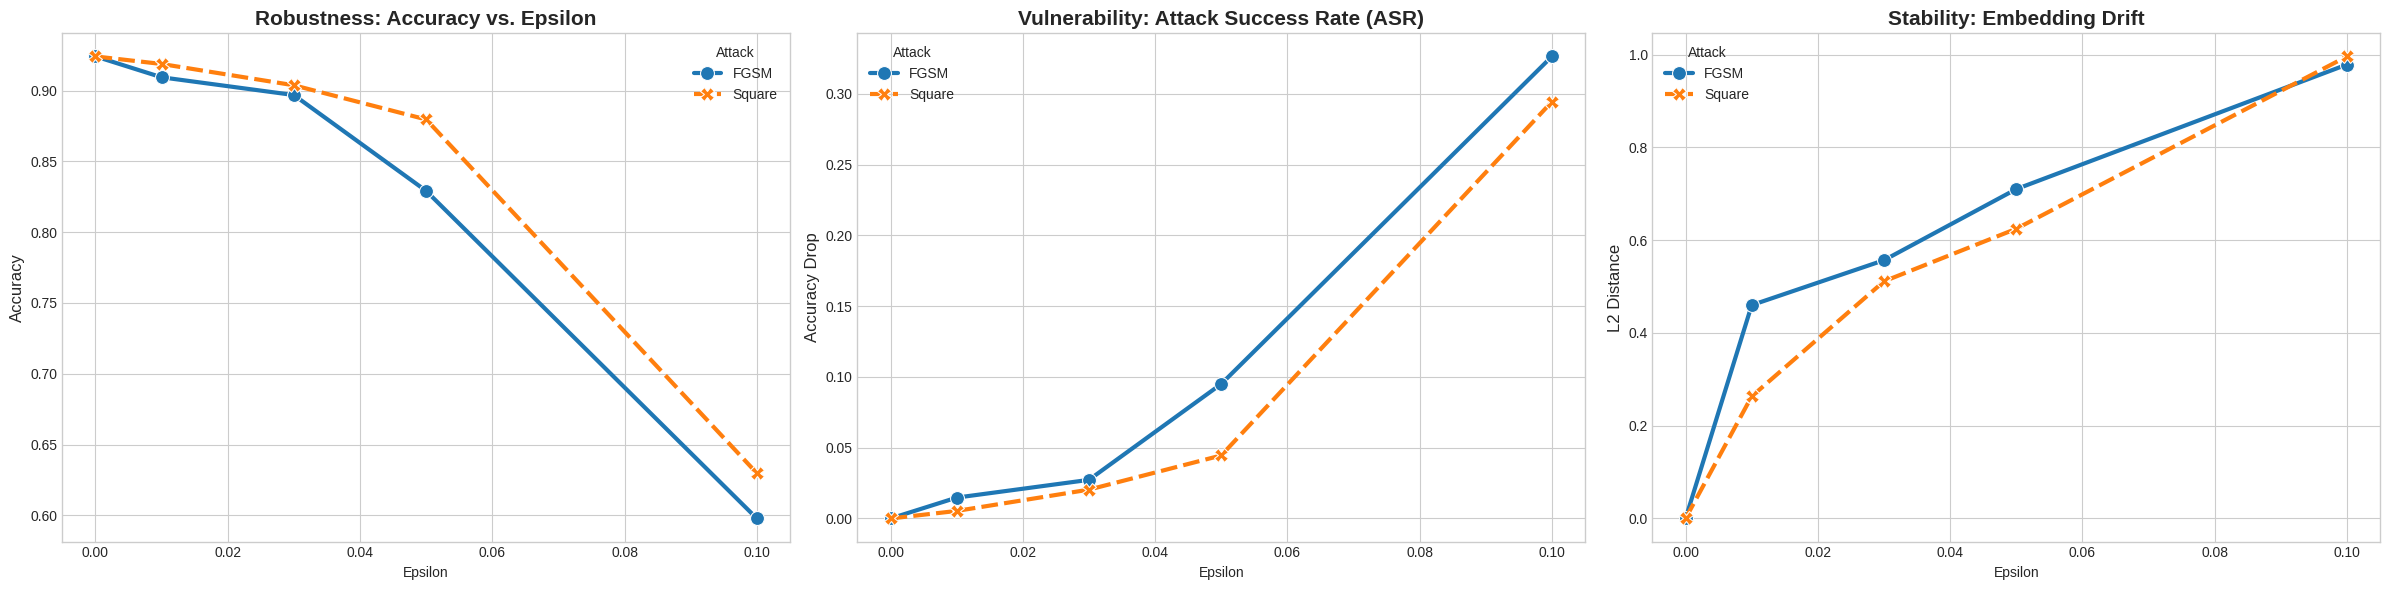

In [17]:




device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
EPSILONS = [0.0, 0.01, 0.03, 0.05, 0.1]
SQUARE_ITER = 20  

print(f"Running Full Evaluation on: {device}")
print("Loading Trained ViT Model...")

model = timm.create_model("hf_hub:gaunernst/vit_tiny_patch8_112.cosface_ms1mv3", pretrained=False).to(device)
checkpoint_path = "vit_curriculum_trained.pth"

if not os.path.exists(checkpoint_path): 
    checkpoint_path = "vit_adversarial_trained.pth"

if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device), strict=False)
    print(f"Weights Loaded from {checkpoint_path}")
else:
    print("WARNING: Model weights file not found! Using random weights.")

model.eval()

valid_gallery_ids = set(gallery_labels_kept)
filtered_probes = []
filtered_labels = []

for face, lbl in zip(probe_faces, probe_labels_kept):
    if lbl in valid_gallery_ids:
        filtered_probes.append(face)
        filtered_labels.append(lbl)

probe_faces_tensor = torch.stack(filtered_probes)
print(f"Valid Test Set: {len(probe_faces_tensor)} images (Full LFW Subset)")

print("Computing Gallery Embeddings...")
gallery_loader = torch.utils.data.DataLoader(torch.stack(gallery_faces), batch_size=64)
gallery_embs = []
with torch.no_grad():
    for batch in gallery_loader:
        batch = batch.to(device)
        gallery_embs.append(F.normalize(model(batch), dim=1))
gallery_embs = torch.cat(gallery_embs)


def get_metrics(probe_emb, probe_lbls, gallery_emb, gallery_lbls):
    sim_matrix = probe_emb @ gallery_emb.T
    max_scores, max_indices = torch.max(sim_matrix, dim=1)
    correct = 0
    total = len(probe_lbls)
    sim_matrix = sim_matrix.cpu()
    for i in range(total):
        if gallery_lbls[max_indices[i].item()] == probe_lbls[i]:
            correct += 1
    return correct, total

def manual_square_attack(model, images, target_embs, eps, n_queries=20):
    """
    Square Attack / Random Search implementation that doesn't drop samples.
    Safe for batch processing.
    """
    if eps == 0: return images
    
    adv_images = images.clone().detach()
    batch_size = images.shape[0]
    
    with torch.no_grad():
        curr_emb = F.normalize(model(adv_images), dim=1)
        best_loss = (curr_emb * target_embs).sum(dim=1) 
    
    for _ in range(n_queries):
        noise = torch.randn_like(images).sign() * eps
        
        candidate = torch.clamp(adv_images + noise, -1, 1)
        
        with torch.no_grad():
            cand_emb = F.normalize(model(candidate), dim=1)
            cand_loss = (cand_emb * target_embs).sum(dim=1)
            
            is_better = cand_loss < best_loss
            
            adv_images[is_better] = candidate[is_better]
            best_loss[is_better] = cand_loss[is_better]
            
    return adv_images

results = []
ATTACKS = ['FGSM', 'Square'] 

print("\n=== Starting Full Evaluation Loop ===")

for eps in EPSILONS:
    print(f"\nProcessing Epsilon: {eps}")
    
    num_batches = (len(probe_faces_tensor) + BATCH_SIZE - 1) // BATCH_SIZE
    attack_stats = {atk: {'correct': 0, 'drift': 0.0} for atk in ATTACKS}
    attack_stats['Clean'] = {'correct': 0, 'drift': 0.0}
    
    batch_iterator = tqdm(range(num_batches), desc=f"Eps {eps}", leave=False)
    
    for i in batch_iterator:
        start = i * BATCH_SIZE
        end = min(start + BATCH_SIZE, len(probe_faces_tensor))
        
        batch_imgs = probe_faces_tensor[start:end].to(device)
        batch_lbls = filtered_labels[start:end]
        
        with torch.no_grad():
            clean_emb = F.normalize(model(batch_imgs), dim=1)
        
        c, t = get_metrics(clean_emb, batch_lbls, gallery_embs, gallery_labels_kept)
        attack_stats['Clean']['correct'] += c
        
        if eps == 0: continue

        for attack_name in ATTACKS:
            if attack_name == 'FGSM':
                img_grad = batch_imgs.clone().detach()
                img_grad.requires_grad = True
                curr = F.normalize(model(img_grad), dim=1)
                loss = (curr * clean_emb).sum() 
                model.zero_grad()
                loss.backward()
                adv_imgs = batch_imgs - eps * img_grad.grad.sign()
                adv_imgs = torch.clamp(adv_imgs, -1, 1)

            elif attack_name == 'Square':
                adv_imgs = manual_square_attack(model, batch_imgs, clean_emb, eps, n_queries=SQUARE_ITER)

            with torch.no_grad():
                adv_emb = F.normalize(model(adv_imgs), dim=1)
            
            acc_c, _ = get_metrics(adv_emb, batch_lbls, gallery_embs, gallery_labels_kept)
            attack_stats[attack_name]['correct'] += acc_c
            
            batch_drift = torch.norm(clean_emb - adv_emb, dim=1).sum().item()
            attack_stats[attack_name]['drift'] += batch_drift

    total_samples = len(probe_faces_tensor)
    clean_acc = attack_stats['Clean']['correct'] / total_samples
    
    if eps == 0:
        for atk in ATTACKS:
             results.append({
                "Attack": atk, "Epsilon": 0.0, 
                "Accuracy": clean_acc, "ASR": 0.0, "Drift": 0.0
            })
    else:
        for atk in ATTACKS:
            acc = attack_stats[atk]['correct'] / total_samples
            drift = attack_stats[atk]['drift'] / total_samples
            asr = max(0, clean_acc - acc)
            
            results.append({
                "Attack": atk, "Epsilon": eps, 
                "Accuracy": acc, "ASR": asr, "Drift": drift
            })

df = pd.DataFrame(results)

print("\n" + "="*50)
print("     FINAL RESULTS (FULL DATASET)")
print("="*50)
print(df.round(4))
print("="*50)

df.to_csv("full_robustness_results.csv", index=False)
print("Results saved to 'full_robustness_results.csv'")

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
plt.style.use('seaborn-v0_8-whitegrid')

sns.lineplot(data=df, x="Epsilon", y="Accuracy", hue="Attack", style="Attack", markers=True, ax=axes[0], linewidth=3, markersize=10)
axes[0].set_title("Robustness: Accuracy vs. Epsilon", fontsize=15, fontweight='bold')
axes[0].set_ylabel("Accuracy", fontsize=12)

sns.lineplot(data=df, x="Epsilon", y="ASR", hue="Attack", style="Attack", markers=True, ax=axes[1], linewidth=3, markersize=10)
axes[1].set_title("Vulnerability: Attack Success Rate (ASR)", fontsize=15, fontweight='bold')
axes[1].set_ylabel("Accuracy Drop", fontsize=12)

sns.lineplot(data=df, x="Epsilon", y="Drift", hue="Attack", style="Attack", markers=True, ax=axes[2], linewidth=3, markersize=10)
axes[2].set_title("Stability: Embedding Drift", fontsize=15, fontweight='bold')
axes[2].set_ylabel("L2 Distance", fontsize=12)

plt.tight_layout()
plt.savefig('final_full_graphs.png')
plt.show()